In [2]:
import pandas as pd
import numpy as np

In [3]:
df=pd.read_csv("E:/Download/tianchi/happiness_train_complete.csv",encoding='ISO-8859-1')
df.head()

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,...,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
0,1,4,1,12,32,59,2015/8/4 14:18,1,1959,1,...,4,50,60,50,50,30.0,30,50,50,50
1,2,4,2,18,52,85,2015/7/21 15:04,1,1992,1,...,3,90,70,70,80,85.0,70,90,60,60
2,3,4,2,29,83,126,2015/7/21 13:24,2,1967,1,...,4,90,80,75,79,80.0,90,90,90,75
3,4,5,2,10,28,51,2015/7/25 17:33,2,1943,1,...,3,100,90,70,80,80.0,90,90,80,80
4,5,4,1,7,18,36,2015/8/10 9:50,2,1994,1,...,2,50,50,50,50,50.0,50,50,50,50


In [5]:
#lightgbm
import pandas as pd
import numpy as np
df=pd.read_csv("E:/Download/tianchi/happiness_train_complete.csv",encoding='ISO-8859-1')
df = df.sample(frac=1,replace=False,random_state=11)
df.reset_index(inplace=True)
df = df[df["happiness"]>0]
Y = df["happiness"]
df["survey_month"] = df["survey_time"].map(lambda line:line.split(" ")[0].split("/")[1]).astype("int64")
df["survey_day"] = df["survey_time"].map(lambda line:line.split(" ")[0].split("/")[2]).astype("int64")
df["survey_hour"] = df["survey_time"].map(lambda line:line.split(" ")[1].split(":")[0]).astype("int64")
X = df.drop(columns=["id","index","happiness","survey_time","edu_other","property_other","invest_other"])

from sklearn.model_selection import train_test_split
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_squared_error
import joblib
#from sklearn.externals import joblib
from sklearn.model_selection import KFold
kfold = KFold(n_splits=15, shuffle = True, random_state= 12)
model = LGBMRegressor(n_jobs=-1,learning_rate=0.051,
                      n_estimators=400,
                      num_leaves=11,
                      reg_alpha=2.0, 
                      reg_lambda=2.1,
                      min_child_samples=6,
                      min_split_gain=0.5,
                      colsample_bytree=0.2
                     )
mse = []
i=0
for train, test in kfold.split(X):
    X_train = X.iloc[train]
    y_train = Y.iloc[train]
    X_test = X.iloc[test]
    y_test = Y.iloc[test]
    model.fit(X_train,y_train)
#     model2.fit(model.predict(X_train,pred_leaf=True),y_train)
#     y_pred = model2.predict(model.predict(X=X_test,pred_leaf=True))
    y_pred = model.predict(X=X_test)
    e = mean_squared_error(y_true=y_test,y_pred=y_pred)
    mse.append(e)
    print(e)
    joblib.dump(filename="light"+str(i),value=model)
    i+=1
print("lightgbm",np.mean(mse),mse)

0.5224377774582052
0.44797541093466153
0.4030650079224266
0.46134571169836247
0.42905483776884656
0.4140137397624459
0.4944787797427342
0.4991647391796767
0.4498245447989843
0.48824311430138173
0.4422957058850986
0.49461511498015176
0.4542557519305272
0.4731815986791866
0.42880513242511314
lightgbm 0.46018379783118685 [0.5224377774582052, 0.44797541093466153, 0.4030650079224266, 0.46134571169836247, 0.42905483776884656, 0.4140137397624459, 0.4944787797427342, 0.4991647391796767, 0.4498245447989843, 0.48824311430138173, 0.4422957058850986, 0.49461511498015176, 0.4542557519305272, 0.4731815986791866, 0.42880513242511314]


In [6]:
#catboost
import pandas as pd
import numpy as np
df=pd.read_csv("E:/Download/tianchi/happiness_train_complete.csv",encoding='ISO-8859-1')
df = df.sample(frac=1,replace=False,random_state=11)
df.reset_index(inplace=True)

df = df[df["happiness"]>0]
Y = df["happiness"]
df["survey_month"] = df["survey_time"].map(lambda line:line.split(" ")[0].split("/")[1]).astype("int64")
df["survey_day"] = df["survey_time"].map(lambda line:line.split(" ")[0].split("/")[2]).astype("int64")
df["survey_hour"] = df["survey_time"].map(lambda line:line.split(" ")[1].split(":")[0]).astype("int64")
X = df.drop(columns=["id","index","happiness","survey_time","edu_other","property_other","invest_other"])


from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import joblib
kfold = KFold(n_splits=15, shuffle = True, random_state= 12)
model = CatBoostRegressor(colsample_bylevel=0.1,thread_count=6,silent=True,iterations=800, 
                          depth=5, 
                          learning_rate=0.051, 
                          loss_function='RMSE',
                          l2_leaf_reg = 3)
mse = []
i=0
for train, test in kfold.split(X):
    X_train = X.iloc[train]
    y_train = Y.iloc[train]
    X_test = X.iloc[test]
    y_test = Y.iloc[test]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    err = mean_squared_error(y_true=y_test,y_pred=y_pred)
    mse.append(err)
    print(err)
    joblib.dump(filename="cat"+str(i),value=model)
    i+=1
print("catboost",np.mean(mse),mse)

0.5140745902446223
0.44963717420374527
0.40583414150925673
0.46129771045939694
0.4155310816111115
0.40941501701181154
0.4998116621189004
0.48265208770060597
0.45761449468465004
0.4895659400203275
0.4398279303183797
0.48314758270880803
0.4551596579865996
0.46339945766808416
0.4220552064306169
catboost 0.4566015823117944 [0.5140745902446223, 0.44963717420374527, 0.40583414150925673, 0.46129771045939694, 0.4155310816111115, 0.40941501701181154, 0.4998116621189004, 0.48265208770060597, 0.45761449468465004, 0.4895659400203275, 0.4398279303183797, 0.48314758270880803, 0.4551596579865996, 0.46339945766808416, 0.4220552064306169]


In [ ]:
#xgboost 

In [8]:
import pandas as pd
import numpy as np
df=pd.read_csv("E:/Download/tianchi/happiness_train_complete.csv",encoding='ISO-8859-1')
df = df.sample(frac=1,replace=False,random_state=11)
df.reset_index(inplace=True)
df = df[df["happiness"]>0]
Y = df["happiness"]
df["survey_month"] = df["survey_time"].map(lambda line:line.split(" ")[0].split("/")[1]).astype("int64")
df["survey_day"] = df["survey_time"].map(lambda line:line.split(" ")[0].split("/")[2]).astype("int64")
df["survey_hour"] = df["survey_time"].map(lambda line:line.split(" ")[1].split(":")[0]).astype("int64")
X = df.drop(columns=["id","index","happiness","survey_time","edu_other","property_other","invest_other"])
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.model_selection import KFold
kfold = KFold(n_splits=15, shuffle = True, random_state= 11)

model = XGBRegressor(max_depth=6,
                     learning_rate=0.01,
                     n_estimators=1565,
                     booster='gbtree',
                     n_jobs=4,
                     gamma=5.4,
                     min_child_weight=6,
                     subsample=0.8,
                     colsample_bytree=1,
                     reg_lambda=1.39,
                     seed=7)


i = 0
for train, test in kfold.split(X):
    mse = []
    X_train = X.iloc[train]
    y_train = Y.iloc[train]
    X_test = X.iloc[test]
    y_test = Y.iloc[test]

    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    xg_mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
    mse.append(xg_mse)
    print("xgboost",xg_mse)
    joblib.dump(filename="xg"+str(i),value=model)
    i+=1
print(np.mean(mse))

xgboost 0.45510003437286745
xgboost 0.4666905550005873
xgboost 0.44662862516306223
xgboost 0.4533487418933676
xgboost 0.44066291631648363
xgboost 0.4775333946833363
xgboost 0.4144352424168406
xgboost 0.4481807520337457
xgboost 0.4795319398216925
xgboost 0.4927121043807029
xgboost 0.4680934937550277
xgboost 0.4323201737836008
xgboost 0.5027756406731756
xgboost 0.43399538303701846
xgboost 0.4768411351758451
0.4768411351758451


xgboost 0.4525480108404593
xgboost 0.46951248589290806
xgboost 0.4515020977772951
xgboost 0.4685559133773186
xgboost 0.43869449193213855
xgboost 0.47639835044954226
xgboost 0.41641651596742
xgboost 0.4533277546327548
xgboost 0.4786136260440723
xgboost 0.49737614512486533
xgboost 0.47082435986030063
xgboost 0.4422682222738635
xgboost 0.5107939675576468
xgboost 0.4315762801135069
xgboost 0.48313271110006084
0.48313271110006084


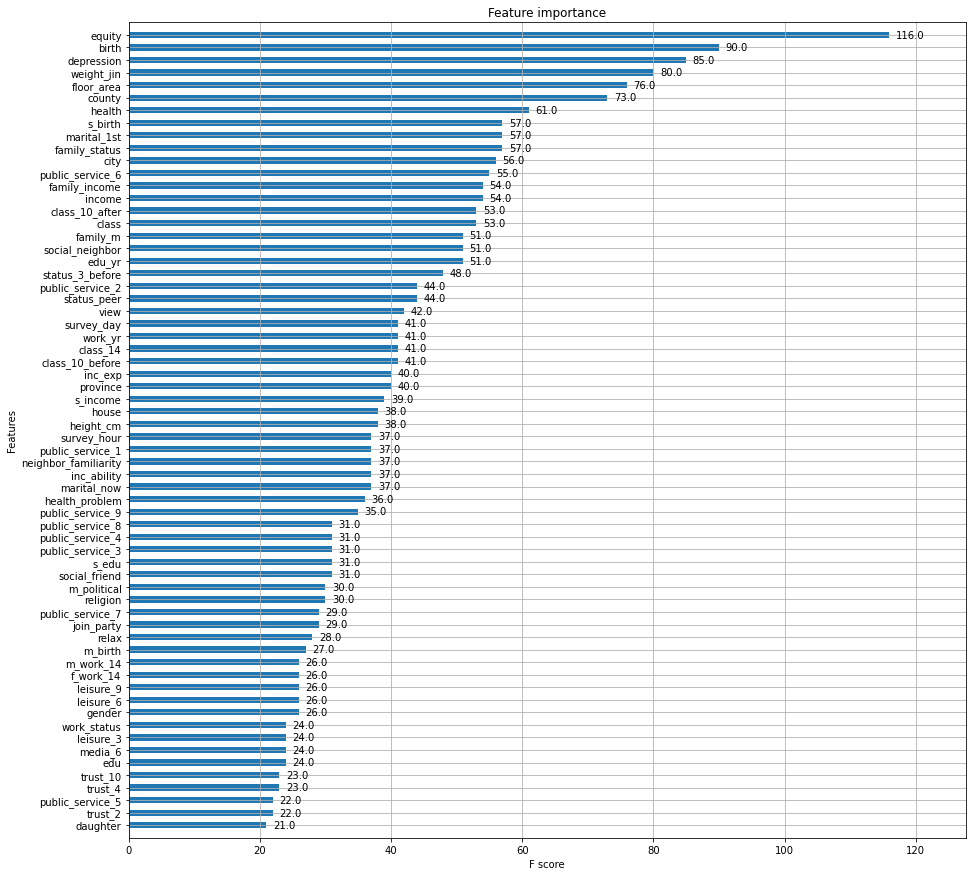

In [17]:
#xgboost 特征分析 subsample=1.0,seed=None,scale_pos_weight=1,reg_alpha=0.1, reg_lambda=1
#random_state=0,objective='reg:linear',
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df=pd.read_csv("E:/Download/tianchi/happiness_train_complete.csv",encoding='ISO-8859-1')
df = df.sample(frac=1,replace=False,random_state=11)
df.reset_index(inplace=True)
df = df[df["happiness"]>0]
Y = df["happiness"]
df["survey_month"] = df["survey_time"].map(lambda line:line.split(" ")[0].split("/")[1]).astype("int64")
df["survey_day"] = df["survey_time"].map(lambda line:line.split(" ")[0].split("/")[2]).astype("int64")
df["survey_hour"] = df["survey_time"].map(lambda line:line.split(" ")[1].split(":")[0]).astype("int64")
X = df.drop(columns=["id","index","happiness","survey_time","edu_other","property_other","invest_other"])
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.model_selection import KFold
from xgboost import plot_tree
from xgboost import plot_importance
kfold = KFold(n_splits=15, shuffle = True, random_state= 11)
model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.1,
       colsample_bytree=0.971, gamma=0.11, learning_rate=0.069, max_delta_step=0,
       max_depth=3, min_child_weight=1, n_estimators=499,
       n_jobs=-1, nthread=50,objective ='reg:squarederror')

i = 0
for train, test in kfold.split(X):
    mse = []
    X_train = X.iloc[train]
    y_train = Y.iloc[train]
    X_test = X.iloc[test]
    y_test = Y.iloc[test]

    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    xg_mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
    mse.append(xg_mse)
    print("xgboost",xg_mse)
    joblib.dump(filename="xg"+str(i),value=model)
    i+=1
print(np.mean(mse))
fig,ax = plt.subplots(figsize=(15,15))
plot_importance(model,
                height=0.5,
                ax=ax,
                max_num_features=64)
plt.show()

In [25]:
#gbdt，min_impurity_split=None, presort='auto',criterion='friedman_mse',
import pandas as pd
import numpy as np
df=pd.read_csv("E:/Download/tianchi/happiness_train_complete.csv",encoding='ISO-8859-1')
df = df.sample(frac=1,replace=False,random_state=11)
df.reset_index(inplace=True)
df = df[df["happiness"]>0]
Y = df["happiness"]
df["survey_month"] = df["survey_time"].map(lambda line:line.split(" ")[0].split("/")[1]).astype("int64")
df["survey_day"] = df["survey_time"].map(lambda line:line.split(" ")[0].split("/")[2]).astype("int64")
df["survey_hour"] = df["survey_time"].map(lambda line:line.split(" ")[1].split(":")[0]).astype("int64")
X = df.drop(columns=["id","index","happiness","survey_time","edu_other","property_other","invest_other"])
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.model_selection import KFold
kfold = KFold(n_splits=15, shuffle = True, random_state= 12)
model = GradientBoostingRegressor(alpha=0.9, init=None,
             learning_rate=0.051, loss='squared_error', max_depth=4, max_features=10,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=600, random_state=3,
             subsample=0.98, verbose=0, warm_start=False)

X.fillna(-8,inplace=True)
mse = []
i = 0
prediction=[]
for train, test in kfold.split(X):
    X_train = X.iloc[train]
    y_train = Y.iloc[train]
    X_test = X.iloc[test]
    y_test = Y.iloc[test]

    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    prediction.append(y_pred)
    gbdt_mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
    mse.append(gbdt_mse)
    print("gbdt",gbdt_mse)
    joblib.dump(filename="gbdt"+str(i),value=model)
    i+=1
print("gbdt",np.mean(mse),mse)



gbdt 0.5189500888507569
gbdt 0.45710877595409216
gbdt 0.4033749775774016
gbdt 0.45943222208389095
gbdt 0.4286129037296931
gbdt 0.42570638271447414
gbdt 0.5043808541694681
gbdt 0.5032374595207704
gbdt 0.45540367596333403
gbdt 0.49633563078272347
gbdt 0.4504290233431699
gbdt 0.4972331370414904
gbdt 0.4568861290691512
gbdt 0.46749694399729685
gbdt 0.4348090029299273
gbdt 0.4639598138485093 [0.5189500888507569, 0.45710877595409216, 0.4033749775774016, 0.45943222208389095, 0.4286129037296931, 0.42570638271447414, 0.5043808541694681, 0.5032374595207704, 0.45540367596333403, 0.49633563078272347, 0.4504290233431699, 0.4972331370414904, 0.4568861290691512, 0.46749694399729685, 0.4348090029299273]


In [29]:
#带权平均融合CatBoostRegressor + xgboost + gbdt现有模型
import pandas as pd
import numpy as np
df=pd.read_csv("E:/Download/tianchi/happiness_train_complete.csv",encoding='ISO-8859-1')
df = df.sample(frac=1,replace=False,random_state=2000)
df.reset_index(inplace=True)

df = df[df["happiness"]>0]
Y = df["happiness"]
df["survey_month"] = df["survey_time"].map(lambda line:line.split(" ")[0].split("/")[1]).astype("int64")
df["survey_day"] = df["survey_time"].map(lambda line:line.split(" ")[0].split("/")[2]).astype("int64")
df["survey_hour"] = df["survey_time"].map(lambda line:line.split(" ")[1].split(":")[0]).astype("int64")
X = df.drop(columns=["id","index","happiness","survey_time","edu_other","property_other","invest_other"])

from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import joblib
kfold = KFold(n_splits=10, shuffle = True, random_state= 110)
catmse = []
lightmse = []
xgmse = []
gbdtmse = []
lrmse = []
i = 0
for train, test in kfold.split(X):
    X_train = X.iloc[train]
    y_train = Y.iloc[train]
    X_test = X.iloc[test]
    y_test = Y.iloc[test]
    
    cat = joblib.load(filename="cat"+str(i))
    light = joblib.load(filename="light"+str(i))
    xg = joblib.load(filename="xg"+str(i))
    gbdt = joblib.load(filename="gbdt"+str(i))
    
    catX = cat.predict(X_test)
    cat_mse = mean_squared_error(y_true=y_test,y_pred=catX)
    print("\ncat mse:",cat_mse)
    catmse.append(cat_mse)
    
#     X_test2 = X_test.drop(columns=["survey_day"])
#     lightX = light.predict(X_test2)
#     light_mse = mean_squared_error(y_true=y_test,y_pred=lightX)
#     print("light mse:",light_mse)
#     lightmse.append(light_mse)
    
    xgX = xg.predict(X_test)
    xg_mse = mean_squared_error(y_true=y_test,y_pred=xgX)
    print("xg mse:",xg_mse)
    xgmse.append(xg_mse)
    X_test2 = X_test.fillna(-8)
    gbdtX = gbdt.predict(X_test2)
    gbdt_mse = mean_squared_error(y_true=y_test,y_pred=gbdtX)
    print("gbdt mse:",gbdt_mse)
    gbdtmse.append(gbdt_mse)
    
    res = np.c_[catX,xgX,gbdtX]
    e = np.array([1/cat_mse,1/xg_mse,1/gbdt_mse])
    y_pred = np.sum(res*e,axis=1)/sum(e)
    lr_mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
    print("lr mse:",lr_mse)
    lrmse.append(lr_mse)
    
    i+=1
    
print("\n\ncatmse:",np.mean(catmse))
# print("lightmse:",np.mean(lightmse))
print("xgmse:",np.mean(xgmse))
print("gbdtmse:",np.mean(gbdtmse))
print("lrmse:",np.mean(lrmse))

cat = CatBoostRegressor(colsample_bylevel=0.1,thread_count=6,silent=True,iterations=800, 
                          depth=5, 
                          learning_rate=0.051, 
                          loss_function='RMSE',
                          l2_leaf_reg = 3)
xg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.1,
       colsample_bytree=0.971, gamma=0.11, learning_rate=0.069, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=499,
       n_jobs=-1, nthread=50, objective='reg:linear', random_state=0,
       reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=None,
       subsample=1.0)
gbdt = GradientBoostingRegressor(alpha=0.9, init=None,
             learning_rate=0.051, loss='ls', max_depth=4, max_features=10,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=600,  random_state=3,
             subsample=0.98, verbose=0, warm_start=False)
cat.fit(X,Y)
xg.fit(X,Y)
gbdt.fit(X.fillna(-8),Y)

df2=pd.read_csv("E:/Download/tianchi/happiness_train_complete.csv",encoding='ISO-8859-1')
df2["survey_month"] = df2["survey_time"].map(lambda line:line.split(" ")[0].split("/")[1]).astype("int64")
df2["survey_day"] = df2["survey_time"].map(lambda line:line.split(" ")[0].split("/")[2]).astype("int64")
df2["survey_hour"] = df2["survey_time"].map(lambda line:line.split(" ")[1].split(":")[0]).astype("int64")
out = df2[["id"]]
X = df2.drop(columns=["id","survey_time","edu_other","property_other","invest_other"])
X2 = X.drop(columns=["survey_day"])
catX = cat.predict(X)
xgX = xg.predict(X)
gbdtX = gbdt.predict(X.fillna(-8))
res = np.c_[catX,xgX,gbdtX]
e = np.array([1/np.mean(catmse),1/np.mean(xgmse),1/np.mean(gbdtmse)])
y_pred = np.sum(res*e,axis=1)/sum(e)
out["happiness"] = y_pred
out.to_csv("happiness_submit0.csv",index=False)
print("done")
print(e)

    


cat mse: 0.3068473087722804
xg mse: 0.36143941064208246
gbdt mse: 0.284963304317945
lr mse: 0.31043439030036707

cat mse: 0.26379334475643545
xg mse: 0.30709277123065803
gbdt mse: 0.2428776867954952
lr mse: 0.26465638645391604

cat mse: 0.3122819689309576
xg mse: 0.3623481326034883
gbdt mse: 0.2899090649776326
lr mse: 0.3141039629133917

cat mse: 0.31720119359048826
xg mse: 0.36844835612016674
gbdt mse: 0.2859330265818493
lr mse: 0.31596803151688657

cat mse: 0.2981851002570271
xg mse: 0.35205155168226326
gbdt mse: 0.2716722895520111
lr mse: 0.2992743284650233

cat mse: 0.27755281034439633
xg mse: 0.318105274497536
gbdt mse: 0.2581780452897828
lr mse: 0.27892291917199

cat mse: 0.32922390966018006
xg mse: 0.37205832761362057
gbdt mse: 0.29988440926202026
lr mse: 0.3263773466845431

cat mse: 0.29257941335360815
xg mse: 0.3249628786801929
gbdt mse: 0.26512869295338437
lr mse: 0.2880887543573236

cat mse: 0.29058454455327043
xg mse: 0.3427706626849523
gbdt mse: 0.26081918866829057
lr mse

C:\Users\Alvis\AppData\Roaming\Python\Python38\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


ValueError: Feature shape mismatch, expected: 137, got 138

In [ ]:
#岭回归 融合CatBoostRegressor + LightGBM + xgboost + gbdt现有模型
import pandas as pd
import numpy as np
df = pd.read_csv("datalab/231702/happiness_train_complete.csv",encoding="GB2312")
df = df.sample(frac=1,replace=False,random_state=11)
df.reset_index(inplace=True)

df = df[df["happiness"]>0]
Y = df["happiness"]
df["survey_month"] = df["survey_time"].map(lambda line:line.split(" ")[0].split("/")[1]).astype("int64")
df["survey_day"] = df["survey_time"].map(lambda line:line.split(" ")[0].split("/")[2]).astype("int64")
df["survey_hour"] = df["survey_time"].map(lambda line:line.split(" ")[1].split(":")[0]).astype("int64")
X = df.drop(columns=["id","index","happiness","survey_time","edu_other","property_other","invest_other"])

from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import train_test_split
kfold = KFold(n_splits=15, shuffle = True, random_state= 12)
catmse = []
lightmse = []
xgmse = []
gbdtmse = []
lrmse = []
i = 0
for train, test in kfold.split(X):
    X_train = X.iloc[train]
    y_train = Y.iloc[train]
    X_test = X.iloc[test]
    y_test = Y.iloc[test]
    
    cat = joblib.load(filename="cat"+str(i))
    light = joblib.load(filename="light"+str(i))
    xg = joblib.load(filename="xg"+str(i))
    gbdt = joblib.load(filename="gbdt"+str(i))
    
    catX = cat.predict(X_test)
    cat_mse = mean_squared_error(y_true=y_test,y_pred=catX)
    print("\ncat mse:",cat_mse)
    catmse.append(cat_mse)

    lightX = light.predict(X_test)
    light_mse = mean_squared_error(y_true=y_test,y_pred=lightX)
    print("light mse:",light_mse)
    lightmse.append(light_mse)
    
    xgX = xg.predict(X_test)
    xg_mse = mean_squared_error(y_true=y_test,y_pred=xgX)
    print("xg mse:",xg_mse)
    xgmse.append(xg_mse)
    
    gbdtX = gbdt.predict(X_test.fillna(-8))
    gbdt_mse = mean_squared_error(y_true=y_test,y_pred=gbdtX)
    print("gbdt mse:",gbdt_mse)
    gbdtmse.append(gbdt_mse)
    
    res = np.c_[catX,lightX,xgX,gbdtX]
    lr = Ridge(fit_intercept=False, alpha=75)
    lr.fit(res,y_test)
    print(lr.coef_)

    y_pred = lr.predict(res)
    lr_mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
    print("lr mse:",lr_mse)
    lrmse.append(lr_mse)
    joblib.dump(filename="lr"+str(i),value=lr)
    i+=1
    
print("\ncatmse:",np.mean(catmse))
print("\n\nlightmse:",np.mean(lightmse))
print("xgmse:",np.mean(xgmse))
print("gbdtmse:",np.mean(gbdtmse))
print("lrmse:",np.mean(lrmse))

df2 = pd.read_csv("datalab/231702/happiness_test_complete.csv",encoding="GB2312")
df2["survey_month"] = df2["survey_time"].map(lambda line:line.split(" ")[0].split("/")[1]).astype("int64")
df2["survey_day"] = df2["survey_time"].map(lambda line:line.split(" ")[0].split("/")[2]).astype("int64")
df2["survey_hour"] = df2["survey_time"].map(lambda line:line.split(" ")[1].split(":")[0]).astype("int64")
out = df2[["id"]]
X = df2.drop(columns=["id","survey_time","edu_other","property_other","invest_other"])
prediction = []
for i in range(15):
    cat = joblib.load(filename="cat"+str(i))
    light = joblib.load(filename="light"+str(i))
    xg = joblib.load(filename="xg"+str(i))
    gbdt = joblib.load(filename="gbdt"+str(i))
    lr = joblib.load(filename="lr"+str(i))
    
    catX = cat.predict(X)
    lightX = light.predict(X)
    xgX = xg.predict(X)
    gbdtX = gbdt.predict(X.fillna(-8))
    rxgb= np.c_[xgX]
    rlgb= np.c_[lightX]
    rcatb= np.c_[catX]
    res = np.c_[catX,lightX,xgX,gbdtX]
    prediction.append(lr.predict(res))
    
    a = np.array(prediction)
def cut(arr):
    arr2 = []
    for x in arr:
        if x<1:
            arr2.append(1)
        elif x>5:
            arr2.append(5)
        else :
            arr2.append(x)
    return arr2

out["happiness"] = np.mean(np.array(prediction),axis=0)

# out["happiness"] = np.array(rxgb)
# out.to_csv("/home/tianchi/myspace/xgb.csv",index=False)
# print("done")
# out["happiness"] = np.array(rcatb)
# out.to_csv("/home/tianchi/myspace/catb.csv",index=False)
# print("done")
# out["happiness"] = np.array(rlgb)
# out.to_csv("/home/tianchi/myspace/lgb.csv",index=False)
# print('done')

# out["happiness"] = cut(np.sum((1/np.array(lrmse)*a.T),axis=1)/np.sum(1/np.array(lrmse)))
out.to_csv("/home/tianchi/myspace/submit05114.csv",index=False)
print("done")
    